# Fantasy Premier League ️⚽️

<p>Dashboard build using jupyter notebook and python displaying your beloved FPL mini league standings and some cool visualiztions 😎.<p>

In [12]:
import numpy as np
import pandas as pd
import requests
import math
import matplotlib.pyplot as plt

In [18]:
class Player:
    def __init__(self, name, rank, points, last_rank, manager_id):
        self.name = name
        self.rank = int(rank)
        self.points = int(points)
        self.last_rank = int(last_rank)
        self.manager_id = manager_id

    def get_rank(self):
        return self.rank

    def get_name(self):
        return self.name

    def get_points(self):
        return self.points
    
    def get_manager_id(self):
        return self.manager_id

    def __str__(self):
        pos = ''
        if self.rank == self.last_rank:
            pos = 'No Movement'
        elif self.rank > self.last_rank:
            move = self.rank - self.last_rank
            pos = f'Fell down by {move} positions'
        else:
            move = self.last_rank - self.rank
            pos = f'Moved up by {move} positions'
        return f'{self.name} with points {self.points} and current rank {self.rank}. {pos}'

class Score:
    def __init__(self, gameweek, points, rank, transfer_cost):
        self.gameweek = gameweek
        self.points = points
        self.rank = rank
        self.transfer_cost = transfer_cost
        
    def get_points(self):
        return self.points
    
    def get_gameweek(self):
        return self.gameweek
    
    def get_rank(self):
        return self.rank
    
    def get_transfer_cost(self):
        return self.transfer_cost
        
    
class Mini_League:
    def __init__(self, name, players):
        self.name = name
        self.players = players
    
    def get_league_name(self):
        return self.name

    def getPlayers(self):
        return self.players

    def __str__(self):
        output = self.name + '\n'
        output = output + '-----------------------------------------------------------------------------------' + '\n'
        for player in self.players:
            output = output + player.__str__() + '\n'
        output = output + '-----------------------------------------------------------------------------------'
        return output
    
class Gameweek:
    def __init__(self, name, avg_score):
        self.name = name
        self.avg_score = avg_score

    def getName(self):
        return self.name

    def getAverageScore(self):
        return self.avg_score

class Chips:
    def __init__(self, name, gw):
        self.name = name
        self.gw = gw
    
    def get_chip_name(self):
        return self.name
    
    def get_gw(self):
        return self.gw


### League Info


In [14]:

#Get gameweek data
def get_static_event_data():
    static_url = f'https://fantasy.premierleague.com/api/bootstrap-static/'
    static_data = requests.get(static_url).json()
    events = static_data['events']
    gameweek_data = []
    for event in events:
        if event['finished'] == True:
            gameweek_data.append(Gameweek(event['name'], int(event['average_entry_score'])))
    return gameweek_data

#Calculate total of average score for all the gameweeks
def get_average_score(gameweek_data):
    total_average = 0
    for i in gameweek_data:
        total_average = total_average + i.getAverageScore()
    return total_average

#Get mini league data
def get_classic_league_standings(league_code):
    league_standing_api_url = f'https://fantasy.premierleague.com/api/leagues-classic/{league_code}/standings'
    league_data = requests.get(league_standing_api_url).json()
    league_name = league_data['league']['name']
    league_standings = league_data['standings']['results']

    players = []
    for standing in league_standings:
        player_data = Player(standing['entry_name'], standing['rank'], standing['total'], standing['last_rank'], standing['entry'])
        players.append(player_data)
    return Mini_League(league_name, players)

league_code = 12902
league_data = get_classic_league_standings(league_code)

In [15]:

print(f'League Name: {league_data.get_league_name()}')

League Name: Greatest show on Paper


### League standings


In [16]:
gw_data = get_static_event_data()

In [17]:
player_total_scores = {}
def get_horizontal_bar_chart(league):
    players = league.getPlayers()
    names = []
    points = []
    colors = []
    total_points = 0

    average_score = get_average_score(gw_data)
    for player in players:
        point = player.get_points()
        total_points = total_points + point
        names.append(player.get_name())
        points.append(point)
        player_total_scores.update({player.get_name():point})
        if point > average_score:
            colors.append('green')
        elif point < average_score:
            colors.append('red')
        else:
            colors.append('blue')

    avg_league_points = total_points/len(points)
    y_pos = np.arange(len(points))
    fig, ax = plt.subplots()
    plt.style.use('dark_background')
    ax.axvline(average_score, color='red', linewidth=1)
    ax.axvline(avg_league_points, color='blue', linewidth=1)
    plt.barh(y_pos, points, color = colors)
    plt.yticks(y_pos, names)
    return plt

,Total Points
Wazza,418
Kneejerk FC,406
Morriss21,398
Tanhaji returns,391
No Brainer XI,386
nochills,340


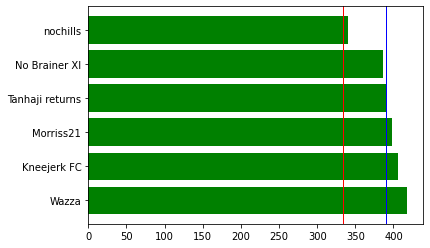

In [7]:
plt = get_horizontal_bar_chart(league_data)
curr_rankings = pd.DataFrame.from_dict(player_total_scores, orient='index', columns=['Total Points'])
curr_rankings

*Horizontal bar chart displaying current mini-league standings. Red line denotes the average FPL points and the blue line denotes the average points of the league.*

In [54]:
chips_column = ['Name','Wildcard','Free Hit','Triple Captain','Bench Boost']
chips_df = pd.DataFrame(columns = chips_column)

def get_manager_scores(manager_id, name):
    request_url = f'https://fantasy.premierleague.com/api/entry/{manager_id}/history/'
    response = requests.get(request_url).json()
    val = response['current']
    scores = []
    wildcard_count = 0
    free_hit_count = 0
    triple_captain_count = 0
    bench_boost_count = 0
    global chips_df
    
    for data in response['chips']:
        chip_name = data['name']
        if chip_name == 'wildcard':
            wildcard_count = wildcard_count + 1
        if chip_name == 'bboost':
            bench_boost_count = bench_boost_count + 1
        if chip_name == 'freehit':
            free_hit_count = free_hit_count + 1
        if chip_name == '3xc':
            triple_captain_count = triple_captain_count + 1
    
    chips_df = chips_df.append(
        pd.Series([name, wildcard_count, free_hit_count, triple_captain_count, bench_boost_count], index = chips_column),
        ignore_index = True)
    
    for data in val:
        score = Score(data['event'], data['points'], data['rank'], data['event_transfers_cost'])
        scores.append(score)
    return scores
    
#get_manager_scores('3836820', 'Wazza')
#get_manager_scores('29759', 'Kneejerk FC')

#### Mini league player scores
Player final score across different gameweeks. 
Final score = points earned - transfer cost

In [55]:
players = league_data.getPlayers()
result = []
player_names = []

for p in players:
    player_names.append(p.get_name())
    p_id = p.get_manager_id()
    scores = get_manager_scores(p_id, p.get_name())
    gw_scores = []
    events1 = []
    for s in scores:
        events1.append(s.get_gameweek())
        gw_scores.append(s.get_points() - s.get_transfer_cost())
    temp = pd.Series(gw_scores, index = events1)
    temp.name = p.get_name()
    result.append(temp)
final_score = pd.DataFrame(result, columns = events1, index = player_names)
final_score

,1,2,3,4,5,6,7
Wazza,100,83,62,60,64,49,5
Kneejerk FC,88,86,59,76,56,41,0
Morriss21,87,68,63,72,48,60,3
Tanhaji returns,78,81,61,56,83,32,5
No Brainer XI,96,60,59,62,65,44,0
nochills,60,47,52,63,49,69,7


#### Mini league player ranks
Player ranks across different gameweeks. In case of tie between players same rank is shared

In [56]:
ranking_array = []
for column in final_score:
    rank_series = pd.to_numeric(final_score[column].rank(method = 'min', ascending = False), downcast='integer')
    ranking_array.append(rank_series)

final_rank =  pd.DataFrame(ranking_array).T
final_rank

,1,2,3,4,5,6,7
Wazza,1,2,2,5,3,3,2
Kneejerk FC,3,1,4,1,4,5,5
Morriss21,4,4,1,2,6,2,4
Tanhaji returns,5,3,3,6,1,6,2
No Brainer XI,2,5,4,4,2,4,5
nochills,6,6,6,3,5,1,1


#### Chips used

In [57]:
chips_df.index = chips_df['Name']
chips_df = chips_df.drop('Name',1)
chips_df

,Wildcard,Free Hit,Triple Captain,Bench Boost
Name,,,,
Wazza,0,0,0,0
Kneejerk FC,1,0,0,0
Morriss21,1,0,0,0
Tanhaji returns,0,0,0,0
No Brainer XI,0,0,0,0
nochills,0,0,0,0


#### Winnings 🤑🤑🤑


In [11]:
gw_entry_cost = 100
#gw_entry_cost = int(gw_entry_cost)
ledger = {}

def update_for_gw_losers(ledger, gw_entry_cost, gw_winner):
    for i,j in ledger.items():
            if i not in gw_winner:
                ledger.update({i: j - gw_entry_cost})
                
for name in player_names:
    ledger[name] = 0

for i in events1:
    a = final_rank[final_rank[i] == 1]
    if len(a.index) == 1:
        gw_winner = a.index[0]
        update_for_gw_losers(ledger, gw_entry_cost, {gw_winner})
        initial_amount = ledger.get(gw_winner)
        ledger.update({gw_winner: initial_amount + ((len(player_names) - 1) * gw_entry_cost)})
    else:
        winners = set()
        for p in range(0,len(a.index)):
            winners.add(a.index[p])
        update_for_gw_losers(ledger, gw_entry_cost, winners)
        amount = ((len(player_names) - len(winners)) * gw_entry_cost) / 2
        amount = round(amount, 2)
        #print(ledger)
        for w in winners:
            initial_amount = ledger.get(w)
            ledger.update({w: initial_amount + amount}) 

final_amount = pd.DataFrame.from_dict(ledger, orient='index', columns=['Net Amount'])
final_amount

,Net Amount
Wazza,50.0
Kneejerk FC,500.0
Morriss21,50.0
Tanhaji returns,50.0
No Brainer XI,-550.0
nochills,50.0
